In [1]:
#basic
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
#for text-preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import one_hot, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#featureengineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
#neuralnets
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout,Input, Concatenate, Convolution1D, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import SimpleRNN, LSTM, Embedding
from keras.callbacks import EarlyStopping, LearningRateScheduler, ModelCheckpoint
from sklearn.model_selection import train_test_split
from keras.optimizers import RMSprop
#embedings
import gensim
from sklearn.cluster import KMeans

Using TensorFlow backend.


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.tail(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
95846,999977655955,"""\nI have discussed it, unlike most of those w...",0,0,0,0,0,0
95847,999982426659,"ps. Almost forgot, Paine don't reply back to t...",1,0,1,0,0,0
95848,999982764066,Mamoun Darkazanli\nFor some reason I am unable...,0,0,0,0,0,0
95849,999986890563,Salafi would be a better term. It is more poli...,0,0,0,0,0,0
95850,999988164717,making wikipedia a better and more inviting pl...,0,0,0,0,0,0


In [4]:
train.comment_text[95846]

'"\nI have discussed it, unlike most of those who revert me (Heonsi is a pure sockpuppet, Caden and Central Data Bank haven\'t discussed at all). I think any unbiased party reading the talk page will see that Rjensen and R41 have been thoroughly refuted and now resort only to the classic pattern of merely repeating their long-countered points as if they were new (e.g. trotting out and even further adding to their meaningless ""sources"" for what is inherently an opinion).   "'

In [5]:
train.comment_text[95847]

"ps. Almost forgot, Paine don't reply back to this shit, I don't want to see/care what you have to say do your bitching out of my sight, plskthxbai."

In [6]:
print( 'train nulls',
train.isnull().sum(),
      'test nulls',
test.isnull().sum(),
sep='\n')

train nulls
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
test nulls
id              0
comment_text    1
dtype: int64


In [7]:
train.comment_text.fillna('unknown', inplace=True)
test.comment_text.fillna('unknown', inplace=True)

In [8]:
classes_ = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## beautify!

Text(0,0.5,'Amount of comments in ds')

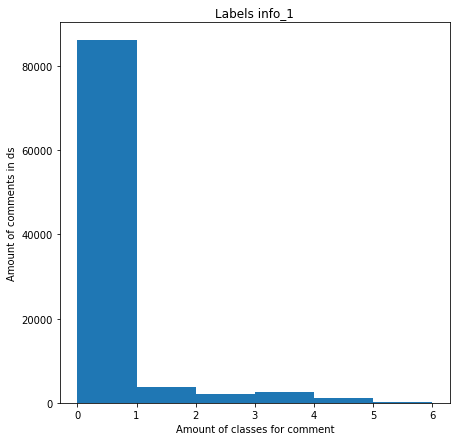

In [9]:
bins = train[classes_].sum(axis=1).unique()
bins.sort()
fig = plt.figure(figsize=(7, 7))
plt.hist(train[classes_].sum(axis=1), bins)
plt.title('Labels info_1')
plt.xlabel('Amount of classes for comment')
plt.ylabel('Amount of comments in ds')

In [10]:
train[classes_].sum(axis=0)

toxic            9237
severe_toxic      965
obscene          5109
threat            305
insult           4765
identity_hate     814
dtype: int64

In [11]:
for i in classes_:
    print('CLASS', i.upper())
    tmp = np.asarray(train[train[i] == 1].comment_text)
    print(tmp[-1])
    print()

CLASS TOXIC
ps. Almost forgot, Paine don't reply back to this shit, I don't want to see/care what you have to say do your bitching out of my sight, plskthxbai.

CLASS SEVERE_TOXIC
98.248.32.178 I will set you on fire, I will shoot your ass up. I will cut your penis off and I will shove it down your throat and choke you. I will cut you up big time motherfucker.

CLASS OBSCENE
ps. Almost forgot, Paine don't reply back to this shit, I don't want to see/care what you have to say do your bitching out of my sight, plskthxbai.

CLASS THREAT
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL Yo

* Comments contain IP-addresses, user names, urls and a lot of other mess. (better to clean up with regex, etc)
* Also some comments contain lots of repetitions. 

I want to add amount of negative words as feature. Here lies dictionary: https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/negative-words.txt
<br> Expanded dict-ry with more offensive words from urban slangs
<br> Added more features

In [15]:
from tqdm import tqdm, tqdm_notebook

In [17]:
neg_words = [i[:-1] for i in open('negative-words.txt')]

In [36]:
neg_words_counts = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in neg_words]))

In [37]:
neg_words_counts_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in neg_words]))

In [57]:
symbs = ['!', '@', '#', '$', '%', '^', '&', '(', '*', '№', '=', '-', '+', '<', '>']
punct = ['.', ',', '\'', ';', ':']
smailes = [':)', ':D', ')']
neg_phrases = ['fuck you', 'screw you', 'kill you', 'beat you', 'die you', 'damn it', 'damn you', 'bitchin out', 'duck face'  ]
short_phrases = ['wtf', 'dgaf', 'fml', 'foad', 'ftw', 'milf']
races_and_orients = ['lesbian', 'gay', 'homo', 'bromance', 'dyke', 'lesbo', 'lezzie', 'faggot', 'nigga', 'nigger', 'jew', 'yankee', 'racist']

In [19]:
symbols_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in symbs]))

In [ ]:
punct_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in punct]))

In [24]:
smailes_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in smailes]))

In [ ]:
len_of_comment = train.comment_text.apply(lambda a: len(a))

In [26]:
capital_letters = train.comment_text.apply(lambda a: len([i for i in a if i.isupper()]))

In [15]:
neg_phrases_count = train.comment_text.apply(lambda a: len([i for i in neg_phrases if i in a]))

In [29]:
short_phrases_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in short_phrases]))

In [49]:
races_and_orients_count = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in races_and_orients]))

In [54]:
count_spaces = train.comment_text.apply(lambda a: len([i for i in a if i == ' ']))
count_ips = train.comment_text.apply(lambda a: len(re.findall("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}", a)))

In [58]:
capital_letters_ts = test.comment_text.apply(lambda a: len([i for i in a if i.isupper()]))
len_of_comment_ts = test.comment_text.apply(lambda a: len(a))
count_spaces_ts = test.comment_text.apply(lambda a: len([i for i in a if i == ' ']))
count_ips_ts = test.comment_text.apply(lambda a: len(re.findall("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}", a)))
punct_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in punct]))
symbols_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in symbs]))
smailes_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in smailes]))
neg_phrases_count_ts = test.comment_text.apply(lambda a: len([i for i in neg_phrases if i in a]))
short_phrases_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in short_phrases]))
races_and_orients_count_ts = test.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in races_and_orients]))

In [39]:
train = train.assign(capital_letters=capital_letters,
                     len_of_comment=len_of_comment,
                     count_ips=count_ips,
                     count_spaces=count_spaces,
                     sybs = symbols_count,
                     smailes = smailes_count,
                     neg_words=neg_words_counts,
                    neg_phrases=neg_phrases_count,
                    short_phrases=short_phrases_count,
                    races_and_orients=races_and_orients_count)

In [40]:
test = test.assign(capital_letters=capital_letters_ts,
                     len_of_comment=len_of_comment_ts,
                     count_ips=count_ips_ts,
                     count_spaces=count_spaces_ts,
                     sybs = symbols_count_ts,
                     smailes = smailes_count_ts,
                     neg_words=neg_words_counts_ts,
                    neg_phrases=neg_phrases_count_ts,
                    short_phrases=short_phrases_count_ts,
                    races_and_orients=races_and_orients_count_ts)

In [41]:
features = ['capital_letters', 'len_of_comment', 'count_ips', 'count_spaces', 'symbs', 'smailes', 'neg_words', 'neg_phrases', 'short_phrases', 'races_and_orients']

* Tokenizing with TweetTokenizer NLTK. (seem to be cool tool:D)

In [42]:
tt = TweetTokenizer(strip_handles=True, reduce_len=True)

In [46]:
def beautify_text(s):
    s = s.replace(':)', 'smile')
    s = s.replace(':D', 'laugh')
    # Removes all characters from string except letters and digits and convert letters to lowercase
    s = re.sub("[^a-zA-Z0-9]", " ", s.lower())
    # Remove new lines
    s = re.sub("\\n","", s)
    # Change urls
    s = re.sub("[a-zA-Z0-9]*(https://)[a-zA-Z0-9.]*", "url", s)
    # Remove IPs
    s = re.sub("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}","", s)
    # Remove usernames
    s = re.sub("\[\[.*\]","", s)
    # Remove numbers
    s = re.sub("\\b[0-9]+\\b", "", s)
    # better use (\w+[0-9])
    # fix grammar
    s = re.sub('\\bf{1,}[a-z]*(ck)\\b', 'fuck', s)
    # find cock symb lol
    s = re.sub('8={1,}D?', 'cock', s)

    #formalize text
    s = s.replace("don\'t", "do not")
    s = s.replace("doesn\'t", "does not")
    s = s.replace("didn\'t", "did not")
    s = s.replace("won\'t", "will not")
    s = s.replace("haven\'t", "have not")
    s = s.replace('haven\\\'t', 'have not')
    #s = s.replace('\'ll', ' will')
    #clean text
    s = s.replace('\\', ' ')
    s = s.replace('\n', '')
    s = s.replace("'s", ' is')
    s = s.replace('“', '')
    s = s.replace('fck', 'fuck')
    s = s.replace('wtf', 'what the fuck')
    s = s.replace('cockwad', 'idiot')
    s = s.replace('скоморохъ', 'buffoon')
    s = s.replace('backash', 'backlash')
    s = s.replace('bizarrethere', 'bizarre there')
    s = s.replace('backash', 'backlash')
    s = s.replace('dummasses', 'dumbass')
    s = s.replace('lesbianswomen', 'lesbian women')
    s = s.replace('bisexualis', 'bisexual')
    s = s.replace('sexualitypenis','sexuality penis')
    s = s.replace('dorkgasm', 'orgasm')
    s = s.replace('cockmy', 'cock my')
    s = s.replace('supertroll', 'super troll')
    s = s.replace('faggotttttttt', 'faggot')
    s = s.replace('sucks50', 'sucks 50')
    s = s.replace('themfuck', 'them fuck')
    s = s.replace('offenderfugitive', 'offender fugitive')
    s = s.replace('creationisrael', 'creation israel')
    s = s.replace('assholestating', 'asshole stating')
    s = s.replace('idiotenough', 'idiot enough')
    s = s.replace('lessblunt', 'less blunt')
    s = s.replace('anticanadian', 'anti canadian')
    s = s.replace('afrikanblack', 'african black')
    s = s.replace('againbitch', 'again bitch')
    s = s.replace('animalfucker', 'animal fucker')
    return s

In [47]:
beautiful_text_tr = train.comment_text.apply(beautify_text)
beautiful_text_ts = test.comment_text.apply(beautify_text)

KeyboardInterrupt: 

In [48]:
words_tr = [tt.tokenize(i) for i in beautiful_text_tr]
words_ts = [tt.tokenize(i) for i in beautiful_text_ts]

NameError: name 'beautiful_text_ts' is not defined

In [ ]:
wnl = WordNetLemmatizer()

In [ ]:
words_tr = [[wnl.lemmatize(j) for j in i] for i in words_tr]

In [ ]:
words_ts = [[wnl.lemmatize(j) for j in i] for i in words_ts]

In [ ]:
words_tr = [[i for i in j if i not in stopwords.words('english')] for j in words_tr]

In [ ]:
words_ts = [[i for i in j if i not in stopwords.words('english')] for j in words_ts]

In [ ]:
text_train_new = [' '.join(i) for i in words_tr]
text_test_new = [' '.join(i) for i in words_ts]

In [ ]:
np.save('train_preproc', words_tr)

In [ ]:
np.save('test_preproc', words_ts)

In [14]:
words_tr = np.load('train_preproc.npy')

In [15]:
words_ts = np.load('test_preproc.npy')

In [16]:
text_train_new = [' '.join(i) for i in words_tr]
text_test_new = [' '.join(i) for i in words_ts]

* TF-IDF using n_gram from 1 to 3

In [17]:
tfv = TfidfVectorizer(min_df=50,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,3),
            use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = 'english')

In [18]:
train_ = tfv.fit_transform(text_train_new)
test_ = tfv.transform(text_test_new)

In [19]:
train_ = pad_sequences(train_.toarray(), maxlen=1500)

In [20]:
test_ = pad_sequences(test_.toarray(), maxlen=1500)

* For embedings I'm gonna use *bag-of-means* (https://arxiv.org/pdf/1509.01626.pdf)<br>
<p>"We also have an experimental model that uses k-means on word2vec learnt from the training subset of each dataset, and then use these learnt means as representatives of the clustered words. We take into consideration all the words that appeared more than 5 times in the training subset. The bag-of-means features are computed the same way as in the bag-of-words model. "

In [187]:
model = gensim.models.Word2Vec(words_tr, min_count=100, size=500)
word_vectors = model.wv.syn0

In [194]:
kmeans_model = KMeans(n_clusters=2800)
idx = kmeans_model.fit_predict(word_vectors)
word_centroid_map = dict(zip(model.wv.index2word, idx ))

In [199]:
model.wv.similar_by_vector(kmeans_model.cluster_centers_[540])

[('fuck', 1.0),
 ('retard', 0.6874533891677856),
 ('asshol', 0.6376489400863647),
 ('motherfuck', 0.617753267288208),
 ('cunt', 0.6025792956352234),
 ('garbag', 0.5999402403831482),
 ('bitch', 0.5947405695915222),
 ('shut', 0.5876146554946899),
 ('shit', 0.5849085450172424),
 ('damn', 0.582467257976532)]

In [207]:
vector_dim = 500
embedding_matrix = np.zeros((len(kmeans_model.cluster_centers_), vector_dim))
for i in range(len(kmeans_model.cluster_centers_)):
    embedding_vector = kmeans_model.cluster_centers_[i]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Idea didn't match the intetions

* GloVe Embedding matrix

In [22]:
vocab_size = 5000
EMBEDDING_DIM = 500

In [23]:
embeddings_index = {}
f = open(os.path.join('./glove-2/glove.twitter.27B.200d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

KeyboardInterrupt: 

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_train_new)

sequences_tr = tokenizer.texts_to_sequences(text_train_new)
sequences_ts = tokenizer.texts_to_sequences(text_test_new)

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

In [ ]:
embedding_matrix = np.zeros((len(word_index)+1, 200))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [78]:
np.save('émbed_matrix', embedding_matrix)

In [21]:
embedding_matrix = np.load('émbed_matrix.npy')

In [22]:
X_train, X_eval, y_train ,y_eval = train_test_split(train_, train[classes_].values, test_size=0.2, random_state=42)

* Bidirectional LSTM

In [45]:
def model_LSTM():
    model_lstm = Sequential()
    model_lstm.add(Embedding(embedding_matrix.shape[0], 200, weights=[embedding_matrix]))
    model_lstm.add(Bidirectional(LSTM(150, recurrent_dropout=0.25 , return_sequences=True)))
    model_lstm.add(GlobalMaxPool1D())
    model_lstm.add(Dropout(0.25))
    model_lstm.add(Dense(50, activation="relu"))
    model_lstm.add(Dropout(0.25))
    model_lstm.add(Dense(6, activation="sigmoid"))
    model_lstm.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])    


    return model_lstm


In [39]:
model_1 = model_LSTM()
batch_size = 32
epochs = 10

In [43]:
checkpoint = ModelCheckpoint('weights.{epoch:03d}-{val_loss:.6f}.hdf5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')


In [40]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4)

In [46]:
def schedule(ind):
    a = [0.001, 0.001, 0.0001, 0.0001, 0.00001, 0.00001, 0.000001]
    return a[ind]
lr = LearningRateScheduler(schedule)
    

In [266]:
X_train.shape

(76680, 8636)

In [47]:
model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_eval, y_eval),
            callbacks=[early_stop, checkpoint, lr])

Train on 76680 samples, validate on 19171 samples
Epoch 1/10
76680/76680 [==============================] - 11528s 150ms/step - loss: 0.1510 - acc: 0.9631 - val_loss: 0.1413 - val_acc: 0.9632
Epoch 2/10
76680/76680 [==============================] - 11821s 154ms/step - loss: 0.1452 - acc: 0.9631 - val_loss: 0.1413 - val_acc: 0.9632
Epoch 3/10
76680/76680 [==============================] - 11845s 154ms/step - loss: 0.1443 - acc: 0.9631 - val_loss: 0.1412 - val_acc: 0.9632
Epoch 4/10
42048/76680 [===============>..............] - ETA: 1:24:01 - loss: 0.1447 - acc: 0.9629

KeyboardInterrupt: 

In [48]:
pred = model_1.predict(X_eval)

In [ ]:
from sklearn.metrics import log_loss
log_loss(y_eval, pred)

0.30001431693307462

In [ ]:
df = pd.DataFrame(np.append(test.id.values.reshape(-1,1), model_1.predict(test_), axis=1), columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
df.id = df.id.apply(lambda a: int(a))

In [ ]:
df.to_csv('submission.csv', index=False)

In [ ]:
np.save('predictions', pred)

* Let's first try Conv+LSTM NeuralNet

 
* Using *sigmoid* on last layer instead of *softmax* 'cause we want probability of each class. So we are using sigmoid on final layer, which gives output in range 0 to 1. If our aim was to find the class, then we will have used softmax 

In [23]:
from sklearn.preprocessing import StandardScaler

In [24]:
from keras.layers import SimpleRNN

In [25]:
inputs = []
embeddings = []
    
input_text = Input((1500,), name = 'comment_text')
input_num = Input((5, ), name = 'numeric')

embedding_text = Embedding(embedding_matrix.shape[0], 200, weights=[embedding_matrix])(input_text)

lstm_layer = (SimpleRNN(150))(embedding_text)

_features_ = [input_num, lstm_layer]
net = Concatenate()(_features_)

net = Dense(150, kernel_initializer = 'he_normal', activation='relu')(net)
net = Dense(50, kernel_initializer = 'he_normal', activation='relu')(net)

output = Dense(6, activation="sigmoid")(net)

model = Model([input_num, input_text], output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

model.summary()

scaler = StandardScaler()
x_num_scaled = scaler.fit_transform(train[features])
tr = [x_num_scaled[:len(X_train)], X_train]
val = [x_num_scaled[len(X_train):], X_eval]

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
comment_text (InputLayer)       (None, 1500)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1500, 200)    24168800    comment_text[0][0]               
__________________________________________________________________________________________________
numeric (InputLayer)            (None, 5)            0                                            
__________________________________________________________________________________________________
simple_rnn_1 (SimpleRNN)        (None, 150)          52650       embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

In [28]:
checkpoint = ModelCheckpoint('weights_srnn.{epoch:03d}-{val_loss:.6f}.hdf5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4)
def schedule(ind):
    a = [0.001, 0.001, 0.0001, 0.0001, 0.00001, 0.00001, 0.000001]
    return a[ind]
lr = LearningRateScheduler(schedule)

In [40]:
tr[0].shape

(76680, 5)

In [29]:
history = model.fit(tr, y_train, batch_size=64, epochs = 6, validation_data=(val, y_eval), 
              callbacks=[lr, early_stop, checkpoint])

Train on 76680 samples, validate on 19171 samples
Epoch 1/6
76680/76680 [==============================] - 1727s 23ms/step - loss: 0.1430 - acc: 0.9631 - val_loss: 0.1417 - val_acc: 0.9632
Epoch 2/6
76680/76680 [==============================] - 2107s 27ms/step - loss: 0.1427 - acc: 0.9631 - val_loss: 0.1418 - val_acc: 0.9632
Epoch 3/6
76680/76680 [==============================] - 2815s 37ms/step - loss: 0.1418 - acc: 0.9631 - val_loss: 0.1413 - val_acc: 0.9632
Epoch 4/6
76680/76680 [==============================] - 1978s 26ms/step - loss: 0.1418 - acc: 0.9631 - val_loss: 0.1412 - val_acc: 0.9632
Epoch 5/6
76680/76680 [==============================] - 1582s 21ms/step - loss: 0.1417 - acc: 0.9631 - val_loss: 0.1412 - val_acc: 0.9632
Epoch 6/6
76680/76680 [==============================] - 1582s 21ms/step - loss: 0.1417 - acc: 0.9631 - val_loss: 0.1412 - val_acc: 0.9632


In [ ]:
scaler = StandardScaler()
x_num_scaled_ts = scaler.fit_transform(test[features])
ts = [x_num_scaled_ts, test_]

df = pd.DataFrame(np.append(test.id.values.reshape(-1,1), model.predict(ts), axis=1), columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
df.id = df.id.apply(lambda a: int(a))
df.to_csv('submission_2.csv', index=False)

In [ ]:
from keras.layers import ConvLSTM2D

In [ ]:
inputs = []
embeddings = []
    
input_text = Input((1500,), name = 'comment_text')
input_num = Input((5, ), name = 'numeric')

embedding_text = Embedding(embedding_matrix.shape[0], 200, weights=[embedding_matrix])(input_text)

lstm_layer = (ConvLSTM2D(filters=150, kernel_size=3))(embedding_text)

_features_ = [input_num, lstm_layer]
net = Concatenate()(_features_)

net = Dense(150, kernel_initializer = 'he_normal', activation='relu')(net)
net = Dense(50, kernel_initializer = 'he_normal', activation='relu')(net)

output = Dense(6, activation="sigmoid")(net)

model = Model([input_num, input_text], output)
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

model.summary()

scaler = StandardScaler()
x_num_scaled = scaler.fit_transform(train[features])
tr = [x_num_scaled[:len(X_train)], X_train]
val = [x_num_scaled[len(X_train):], X_eval]

In [ ]:
checkpoint = ModelCheckpoint('weights_cnn.{epoch:03d}-{val_loss:.6f}.hdf5', 
                             monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early_stop = EarlyStopping(monitor='val_loss',
                           patience=4,
                           verbose=1,
                           min_delta=1e-4)
def schedule(ind):
    a = [0.001, 0.001, 0.0001, 0.0001, 0.00001, 0.00001, 0.000001]
    return a[ind]
lr = LearningRateScheduler(schedule)

In [ ]:
history = model.fit(tr, y_train, batch_size=64, epochs = 6, validation_data=(val, y_eval), 
              callbacks=[lr, early_stop, checkpoint])

In [ ]:
df = pd.DataFrame(np.append(test.id.values.reshape(-1,1), model.predict(ts), axis=1), columns=['id', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])
df.id = df.id.apply(lambda a: int(a))
df.to_csv('submission_1.csv', index=False)